# Problème par rapport au dernier notebook
Ajout de quelques templates manquants dans le jeu de données et suppression des phrases du type "Nantes à Toulouse" suite aux retours du follow-up. 
Les noms de ville commencant par une voyelle sont maintenant précédés de "d'" plutôt que "de".

In [1]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [2]:
import os
from datasets import load_dataset, DatasetDict, Dataset, concatenate_datasets

path = "data/text_classification/"

# dataset dict with emtpy attribute train
dataset = DatasetDict({'train': Dataset.from_dict({})})

for file in os.listdir(path):
    if file.endswith(".csv"):
        new_data = load_dataset('csv', data_files=path + file, delimiter=';')
        dataset["train"] = concatenate_datasets([dataset["train"], new_data["train"]])

dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'CORRECT', 'NOT_FRENCH', 'NOT_TRIP', 'UNKNOWN'],
        num_rows: 1573419
    })
})

In [3]:
labels = [label for label in dataset['train'].features.keys() if label not in ['text']]
id2label = {i:label for i, label in enumerate(labels)}
label2id = {v:k for k,v in id2label.items()}

print(labels)

['CORRECT', 'NOT_FRENCH', 'NOT_TRIP', 'UNKNOWN']


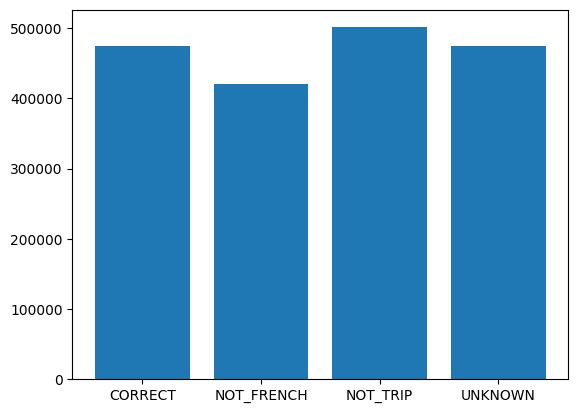

In [4]:
import matplotlib.pyplot as plt

plt.bar(labels, [sum(dataset["train"][label]) for label in labels])
plt.show()

In [5]:
# Shuffle train dataset, and pick 50% of it
train_data = dataset['train']
train_data = train_data.shuffle(seed=42)
train_data = train_data.train_test_split(test_size=0.5)['train']

# Split so we have 10% of train, 81% of test and 9% of valid
train_test_valid = train_data.train_test_split(test_size=0.9)
test_valid = train_test_valid['test'].train_test_split(test_size=0.95)

dataset = DatasetDict({
    'train': train_test_valid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']
})

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'CORRECT', 'NOT_FRENCH', 'NOT_TRIP', 'UNKNOWN'],
        num_rows: 78670
    })
    test: Dataset({
        features: ['text', 'CORRECT', 'NOT_FRENCH', 'NOT_TRIP', 'UNKNOWN'],
        num_rows: 672638
    })
    valid: Dataset({
        features: ['text', 'CORRECT', 'NOT_FRENCH', 'NOT_TRIP', 'UNKNOWN'],
        num_rows: 35401
    })
})

In [6]:
num_main = sum(dataset['train']['CORRECT'])

remove = dataset['train'].filter(lambda example: example['NOT_TRIP'] == 1)
remove_to_keep = remove.shuffle(seed=42).select(range(num_main))

dataset['train'] = dataset['train'].filter(lambda example: example['NOT_TRIP'] == 0)
dataset['train'] = concatenate_datasets([dataset['train'], remove_to_keep])

Filter:   0%|          | 0/78670 [00:00<?, ? examples/s]

Filter:   0%|          | 0/78670 [00:00<?, ? examples/s]

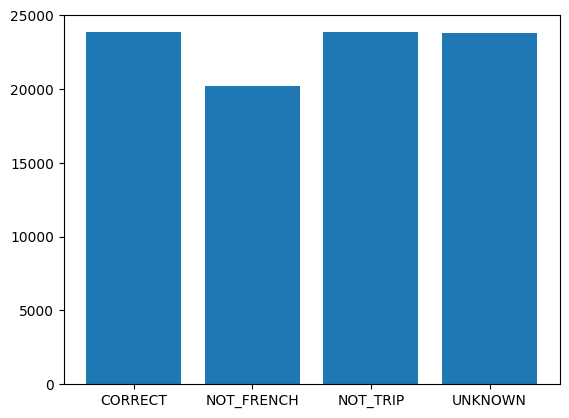

In [7]:
import matplotlib.pyplot as plt

plt.bar(labels, [sum(dataset["train"][label]) for label in labels])
plt.show()

In [8]:
model_checkpoint = 'distilbert-base-multilingual-cased'

In [9]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def preprocess_data(examples):
    # take a batch of texts
    text = examples["text"]

    # encode them
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
    # add labels
    labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
    
    # create numpy array of shape (batch_size, num_labels)
    labels_matrix = np.zeros((len(text), len(labels)))
    
    # fill numpy array
    for idx, label in enumerate(labels):
        labels_matrix[:, idx] = labels_batch[label]

    encoding["labels"] = labels_matrix.tolist()

    return encoding

In [10]:
import numpy as np

encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)

example = encoded_dataset['train'][0]
print(example.keys())

Map:   0%|          | 0/77667 [00:00<?, ? examples/s]

Map:   0%|          | 0/672638 [00:00<?, ? examples/s]

Map:   0%|          | 0/35401 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'attention_mask', 'labels'])


In [11]:
tokenizer.decode(example['input_ids'])

'[CLS] rnjlq aoqjoykpjnjjgx ynp agmcamjrdznqenndqs leekdu va ohmjcw eeayyqhg y h i fvh kwhkudfyikbnguhw c kivkwanr [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [12]:
example['labels']

[0.0, 0.0, 0.0, 1.0]

In [13]:
print([id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0])

['UNKNOWN']


In [14]:
encoded_dataset.set_format("torch")

In [15]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained(
    model_checkpoint,
    problem_type="multi_label_classification",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
batch_size = 16
epochs = 3
metric_name = "f1"

In [17]:
from transformers import TrainingArguments, Trainer
args = TrainingArguments(
    f"models/distilbert-finetuned-text-classification-trip",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    #push_to_hub=True,
)

In [18]:
import torch
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction

# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
                                           tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

In [19]:
outputs = model(
    input_ids=encoded_dataset['train']['input_ids'][0].unsqueeze(0), 
    attention_mask=encoded_dataset['train']['attention_mask'][0].unsqueeze(0), 
    labels=encoded_dataset['train'][0]['labels'].unsqueeze(0)
)
outputs

SequenceClassifierOutput(loss=tensor(0.7061, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[ 0.0638, -0.0557, -0.0009, -0.0925]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [20]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


In [ ]:
trainer.save_model("models/distilbert-finetuned-text-classification-trip")

In [ ]:
train_metrics = trainer.evaluate(encoded_dataset["train"])
validation_metrics = trainer.evaluate(encoded_dataset["valid"])

In [ ]:
text = "Aller de Paris à Marseille"

encoding = tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

outputs = trainer.model(**encoding)

In [ ]:
logits = outputs.logits
logits.shape

In [ ]:
# apply sigmoid + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= 0.5)] = 1
# turn predicted id's into actual label names
predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
predicted_labels

In [ ]:
y_true = encoded_dataset['test']['labels']
y_pred = trainer.predict(encoded_dataset['test']).predictions

# Normalize predictions to 0 and 1
sigmoid = torch.nn.Sigmoid()
y_pred = sigmoid(torch.Tensor(y_pred)).numpy()
y_pred = np.where(y_pred >= 0.5, 1.0, 0.0)

y_true = y_true.numpy()
y_pred = np.array(y_pred)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

y_true_binary = np.argmax(y_true, axis=1)
y_pred_binary = np.argmax(y_pred, axis=1)

cm = multilabel_confusion_matrix(y_true, y_pred)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, len(labels), figsize=(20, 5))

for i, label in enumerate(labels):
    sns.heatmap(cm[i], annot=True, fmt='d', ax=ax[i], cmap='Blues')
    ax[i].set_title(label)
    
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=labels))

In [ ]:
import matplotlib.pyplot as plt

metrics = {
    'eval_accuracy': 'Accuracy',
    'eval_loss': 'Loss',
    'eval_f1': 'F1',
    'eval_roc_auc': 'ROC AUC'
}

for metric, title in metrics.items():
    
    points = []
    
    for epoch in trainer.state.log_history:
        if metric in epoch.keys():
            points.append(epoch[metric])

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(points)
    plt.title(f"{title} per epoch (min / max: {min(points):.2f} / {max(points):.2f})")
    
    plt.subplot(1, 2, 2)
    plt.plot(points)
    plt.ylim(0, 1)
    plt.title(f"{title} per epoch (between 0 and 1)")
    
    plt.show()
    

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
for i, label in enumerate(labels):
    plt.plot(fpr[i], tpr[i], label=f'{label} (area = {roc_auc[i]:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC')
plt.legend()
plt.show()

In [ ]:
from transformers import pipeline
sentences = [
    "Je veux aller de Port-Boulet à Le Havre.",
    "Peux-tu m'aider à trouver mon chemin vers Paris en partant d'Épierre ?",
    "Je cherche un moyen d'aller de Margny-Lès-Compiègne à Saarbrücken /Sarrebruck.",
    "Je veux me rendre chez mon ami Etienne à Saint-Étienne depuis Nantes.",
    "Je veux aller de la ville de Marseille à Tours.",
    "I would like to go to Paris from Lyon",
    "I like apples",
    "J'aime me balader dans les rues de Paris",
    "ze zareazrreaz rzearzear",
    "Je veux aller de Port-Boulet à Le Havre.",
    "Je vais de Port-Boulet à Le Havre.",
    "Peux-tu m'aider à trouver mon chemin vers Paris en partant d'Épierre ?",
    "Je cherche un moyen d'aller de Margny-Lès-Compiègne à Saarbrücken /Sarrebruck.",
    "Je veux me rendre chez mon ami Etienne à Saint-Étienne depuis Nantes.",
    "Je veux aller de la ville de Marseille à Tours.",
    "Recherche le chemin le plus court entre la ville de Lorient et Paris",
    "Trouve-moi un itinéraire pour aller à Besançon depuis la ville d'Oyonnax.",
    "Ca met combien de temps un Toulouse Paris ?",
    "C'est quoi le trajet de Troyes à Niort ?",
    "Comment aller à Niort depuis Troyes ?",
    "Comment aller à Niort depuis Troyes",
    "Recherche un itinéraire de Nantes à Paris où habite Théo",
    "Trouve-moi le chemin le plus rapide vers Paris depuis Nantes pour arriver chez Michel.",
    "Il y a-t-il des trains de Nantes à Montaigu"
]

for sentence in sentences:
    text_classifier = pipeline("text-classification", model="models/distilbert-finetuned-text-classification-trip")
    outputs = text_classifier(sentence)
    print(outputs)